In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.nn import functional as F
import torch.optim as optim


In [2]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None, is_test=False):
        super().__init__()
        self.data = csv_file        # 存储包含「图片路径」和「标签」的DataFrame
        self.root_dir = root_dir    # 图片文件存储的根目录
        self.transform = transform  # 数据预处理/增强的变换组合（如缩放、裁剪、归一化）
        self.is_test = is_test      # 标志位，区分是测试集（无标签）还是训练/验证集

    @property
    def classes(self):
        return self.data.iloc[:, 1].unique().tolist()
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        # 1. 构建图片完整路径并读取
        img_path = os.path.join(self.root_dir, self.data.iloc[idx, 0]) # 假设CSV第一列是图片相对路径
        image = Image.open(img_path) # 用PIL库打开图片

        # 2. 应用数据变换
        if self.transform:
            image = self.transform(image) # 例如转为Tensor、归一化等

        # 3. 如果是测试集，只返回图片
        if self.is_test:
            return image

        # 4. 如果是训练集/验证集，获取标签并返回(图片, 标签)对
        label = self.data.iloc[idx, 2] # 假设CSV的第三列是标签（可能是数字编码后的）
        label = torch.tensor(label)    # 将标签转为Tensor

        return image, label


In [3]:
img_size = 256
train_transforms = transforms.Compose([
        transforms.Resize(img_size),        # 统一缩放图像尺寸
        transforms.RandomHorizontalFlip(), # 随机水平翻转（数据增强）
        transforms.RandomVerticalFlip(),   # 随机垂直翻转（数据增强）
        transforms.ToTensor(),             # 将PIL图像转为Tensor，并缩放到[0,1]
        ])
test_transforms = transforms.Compose([
        transforms.Resize(img_size),       # 同样统一尺寸
        transforms.ToTensor(),             # 转为Tensor
])

data_folder = '../data'
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv(data_folder+ '/test.csv')


In [4]:
leaves_labels = train_df.iloc[:,1].unique()
n_classes = len(leaves_labels)
class_to_num = dict(zip(leaves_labels, range(n_classes)))
train_df['labelEncoded'] = train_df.iloc[:, 1].map(class_to_num)

In [5]:
full_dataset = CustomDataset(train_df, data_folder, transform=train_transforms)
predict_dataset = CustomDataset(test_df, data_folder, transform=test_transforms, is_test=True)
class_names = full_dataset.classes

train_size = int(0.9 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

batch_size = 128
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
dataloader = {'train':train_dataloader,'test':test_dataloader}
print(f"train size:{train_size},test size:{test_size}")

train size:16517,test size:1836


In [6]:
class_to_num

{'maclura_pomifera': 0,
 'ulmus_rubra': 1,
 'broussonettia_papyrifera': 2,
 'prunus_virginiana': 3,
 'acer_rubrum': 4,
 'cryptomeria_japonica': 5,
 'staphylea_trifolia': 6,
 'asimina_triloba': 7,
 'diospyros_virginiana': 8,
 'tilia_cordata': 9,
 'ulmus_pumila': 10,
 'quercus_muehlenbergii': 11,
 'juglans_cinerea': 12,
 'cercis_canadensis': 13,
 'ptelea_trifoliata': 14,
 'acer_palmatum': 15,
 'catalpa_speciosa': 16,
 'abies_concolor': 17,
 'eucommia_ulmoides': 18,
 'quercus_montana': 19,
 'koelreuteria_paniculata': 20,
 'liriodendron_tulipifera': 21,
 'styrax_japonica': 22,
 'malus_pumila': 23,
 'prunus_sargentii': 24,
 'cornus_mas': 25,
 'magnolia_virginiana': 26,
 'ostrya_virginiana': 27,
 'magnolia_acuminata': 28,
 'ilex_opaca': 29,
 'acer_negundo': 30,
 'fraxinus_nigra': 31,
 'pyrus_calleryana': 32,
 'picea_abies': 33,
 'chionanthus_virginicus': 34,
 'carpinus_caroliniana': 35,
 'zelkova_serrata': 36,
 'aesculus_pavi': 37,
 'taxodium_distichum': 38,
 'carya_tomentosa': 39,
 'picea_p

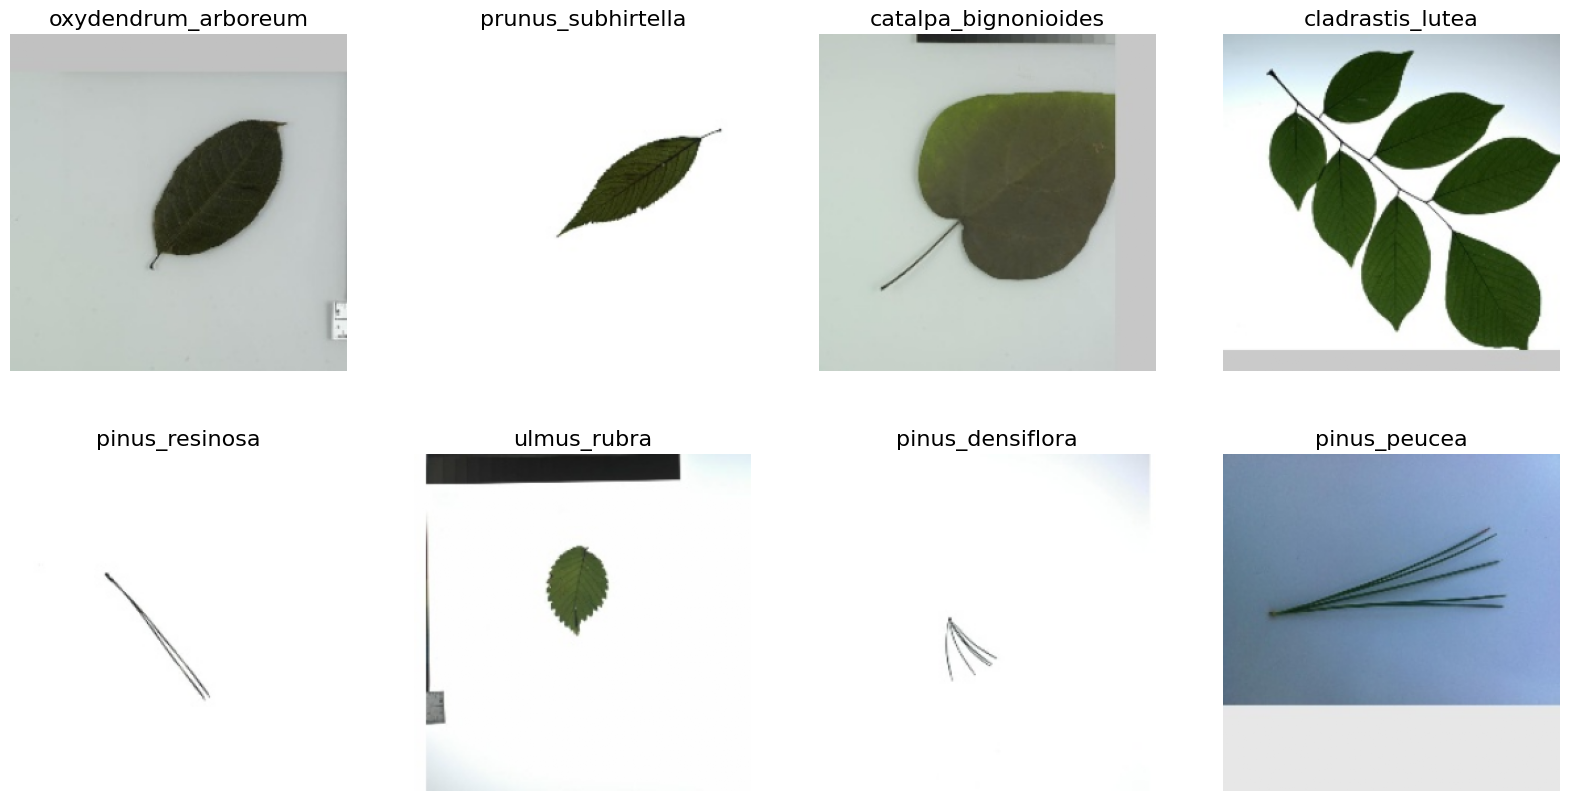

In [7]:
data_iter = iter(train_dataloader)
imgs, labels = next(data_iter)
classes = full_dataset.classes

fig, axes = plt.subplots(2, 4, figsize=(20,10))  # 2 行 4 列
for i, ax in enumerate(axes.flatten()):
    img = imgs[i].detach().cpu().permute(1,2,0).numpy().clip(0,1)
    ax.imshow(img)
    ax.set_title(classes[labels[i].item()],fontsize=16)
    ax.axis("off")
plt.show()

In [13]:
class Residual(nn.Module):
    def __init__(self, input_channels, num_channels, 
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels, 
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels, 
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels, 
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)
    
    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)
    
def resnet_block(input_channels, num_channels, num_residuals,
                first_block=False):
    block = []
    for i in range(num_residuals):
        if i ==0 and not first_block:
            block.append(Residual(input_channels, num_channels, 
                                use_1x1conv=True, strides=2))
        else:
            block.append(Residual(num_channels, num_channels))
    return block

def resNet_18(num_classes):
    b1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3), 
                       nn.BatchNorm2d(64),nn.ReLU(),
                        nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
    b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
    b3 = nn.Sequential(*resnet_block(64, 128, 2))
    b4 = nn.Sequential(*resnet_block(128, 256, 2))
    b5 = nn.Sequential(*resnet_block(256, 512, 2))
    return nn.Sequential(b1, b2, b3, b4, b5, 
                        nn.AdaptiveAvgPool2d((1,1)),
                        nn.Flatten(), nn.Linear(512, num_classes))

net = resNet_18(num_classes=100)
X = torch.rand(size=(1, 3, 256, 256))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 64, 64])
Sequential output shape:	 torch.Size([1, 64, 64, 64])
Sequential output shape:	 torch.Size([1, 128, 32, 32])
Sequential output shape:	 torch.Size([1, 256, 16, 16])
Sequential output shape:	 torch.Size([1, 512, 8, 8])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 100])


In [9]:
def claculate_accuracy(model, data_loader, device):
    correct = 0
    total = 0
    # model.eval()  # Put model in evaluation mode
    
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    return correct/total

In [10]:
def train(model,dataloaders,epochs,criterion,optimizer,device):
    for epoch in range(epochs):
        for batch_idx, (data, target) in enumerate(dataloaders['train']):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            if batch_idx % 100 == 0:
                train_accuracy = claculate_accuracy(model,dataloaders['train'],device)
                test_accuracy = claculate_accuracy(model,dataloaders['test'],device)
                print(f"epoch: {epoch} ",
                      f"[{batch_idx * batch_size}/{len(dataloaders['train'].dataset)} ({100. * batch_idx / len(dataloaders['train']):.0f}%)]\t"
                      f"loss: {loss.item():.6f}\t ",
                      f"train accuracy: {100. * test_accuracy :.2f}%\t",
                      f"test accuracy:  {100.  * train_accuracy:.2f}%")

In [11]:
train_on_gpu = torch.cuda.is_available()
if train_on_gpu:
    print('Training on GPU.')
else:
    print('No GPU available, training on CPU.')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Training on GPU.


In [14]:
# batch_size = 128
img_size  = 48
epochs = 10

model = resNet_18(len(class_names))
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train(model,dataloader,epochs,criterion,optimizer,device)

epoch: 0  [0/16517 (0%)]	loss: 5.244629	  train accuracy: 1.03%	 test accuracy:  1.15%
epoch: 0  [12800/16517 (77%)]	loss: 3.695439	  train accuracy: 8.93%	 test accuracy:  9.71%
epoch: 1  [0/16517 (0%)]	loss: 3.612177	  train accuracy: 9.75%	 test accuracy:  10.66%
epoch: 1  [12800/16517 (77%)]	loss: 2.991789	  train accuracy: 22.17%	 test accuracy:  22.15%
epoch: 2  [0/16517 (0%)]	loss: 3.071105	  train accuracy: 15.36%	 test accuracy:  16.87%
epoch: 2  [12800/16517 (77%)]	loss: 2.375922	  train accuracy: 31.64%	 test accuracy:  33.53%
epoch: 3  [0/16517 (0%)]	loss: 2.503002	  train accuracy: 29.58%	 test accuracy:  29.45%
epoch: 3  [12800/16517 (77%)]	loss: 1.819872	  train accuracy: 40.09%	 test accuracy:  43.54%
epoch: 4  [0/16517 (0%)]	loss: 2.190582	  train accuracy: 37.04%	 test accuracy:  37.20%
epoch: 4  [12800/16517 (77%)]	loss: 1.635038	  train accuracy: 46.30%	 test accuracy:  50.13%
epoch: 5  [0/16517 (0%)]	loss: 1.642644	  train accuracy: 41.12%	 test accuracy:  44.58%
e